In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
from tqdm import tqdm
from itertools import product
from dataclasses import dataclass
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from typing import List, Dict
from CommonFunctions import enhance_plot
from Models import SimpleCNN, ModularVGG
from Utils import *
%matplotlib inline

In [3]:
PARAMS = LearningParameters()
PARAMS.dropout = 0
PARAMS.batch_norm = False
KERNEL_PARAMS = dict(kernel_size=3, stride=1, padding=1)
def VGG11():
    model_config = dict(
        CONV=dict(
            conv_layers=[[64],
                         [128],
                         [256, 256],
                         [512, 512],
                         [512, 512]],
            kernel_params=KERNEL_PARAMS,
            batch_norm=PARAMS.batch_norm
        ),
        FC=dict(
            layer_sizes=[4096, 4096, 1000],
            dropout=PARAMS.dropout
        )
    )
    return ModularVGG(input_layer_size=3,
                      num_of_classes=10,
                      image_size=32,
                      config=model_config)
PARAMS

LearningParameters(batch_size=128, cpu_count=12, learning_rate=0.05, momentum=0.1, weight_decay=0.001, epochs=150, device=device(type='cuda'), dropout=0, batch_norm=False)

In [4]:
def l1_l2_regularization(model, lambda_l1, lambda_l2):
    l1_loss = sum(torch.sum(torch.abs(param)) for param in model.parameters())
    l2_loss = sum(torch.sum(param ** 2) for param in model.parameters())
    return lambda_l1 * l1_loss + lambda_l2 * l2_loss

def train_step_with_reg(model, dataloader, criterion, accuracy_function, optimizer, device,
                        lambda_l1=0, lambda_l2=0):
    train_loss, accuracy = 0, 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        mse_loss = criterion(y_pred, y)
        reg_loss = l1_l2_regularization(model, lambda_l1, lambda_l2)
        # print(mse_loss, reg_loss)
        loss = mse_loss + reg_loss
        accuracy += accuracy_function(y_pred.argmax(dim=1), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= (data_len := len(dataloader))
    accuracy /= data_len
    return train_loss, accuracy


def plot_loss(title, epochs, loss_dict, axes_size, file):
    with plt.style.context('cyberpunk'):
        figure, axes = plt.subplots(*axes_size, layout='constrained', figsize=(6, 8))
        x_axis = range(1, epochs + 1)
        for ax, ((L1, L2), (loss_train, loss_val)) in zip(figure.axes, loss_dict.items()):
            ax.plot(x_axis, loss_train, label='Train')
            ax.plot(x_axis, loss_val, label='Test')
            ax.set(title=f'L1 = {L1:.2f}\nL2 = {L2:.2f}')
            enhance_plot(figure, axes, glow=True, alpha_gradient=0.4)
        figure.suptitle(title)
        figure.savefig(f'./images/{file}.png')

# SimpleCNN with L1, L2 and no regularization

In [5]:
data_path = Path('./data')
models_data = {'SimpleCNN': {}}
_, _, train_dataloader, test_dataloader = load_CIFAR10(
    data_path, normalized_transform(), subset=(10000, 3000))

L1, L2 = 2.e-5, 2.e-4
PARAMS.learning_rate = 0.01
PARAMS.batch_size = 128
PARAMS.epochs = 100
PARAMS.momentum = 0.3
L1_list = [0, L1, 0, L1]
L2_list = [0, 0, L2, L2]
model_names = ['Vanilla', 'L1 regularization', 'L2 regularization', 'ElasticNet']

for model_name, L1, L2 in zip(model_names, L1_list, L2_list):
    print(model_name)
    model = SimpleCNN()
    model.to(PARAMS.device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=PARAMS.learning_rate,
                                momentum=PARAMS.momentum)
    train_time_start = timer()
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    for epoch in tqdm(range(PARAMS.epochs)):
        train_metrics = train_step_with_reg(
            model, train_dataloader, loss_fn, accuracy, optimizer, PARAMS.device,
            lambda_l1=L1, lambda_l2=L2)
        test_metrics = test_step(
            model, test_dataloader, loss_fn, accuracy, PARAMS.device)
        train_loss.append(train_metrics[0])
        train_acc.append(train_metrics[1])
        val_loss.append(test_metrics[0])
        val_acc.append(test_metrics[1])
    models_data['SimpleCNN'][model_name] = (train_loss, train_acc, val_loss, val_acc, model)
    train_time = timer() - train_time_start
    print(f'Time: {train_time:.3f} seconds')

Vanilla


100%|██████████| 100/100 [08:57<00:00,  5.37s/it]


Time: 537.251 seconds
L1 regularization


100%|██████████| 100/100 [08:58<00:00,  5.39s/it]


Time: 538.624 seconds
L2 regularization


100%|██████████| 100/100 [08:37<00:00,  5.18s/it]


Time: 517.549 seconds
Both Regularizations


100%|██████████| 100/100 [08:34<00:00,  5.15s/it]

Time: 514.727 seconds


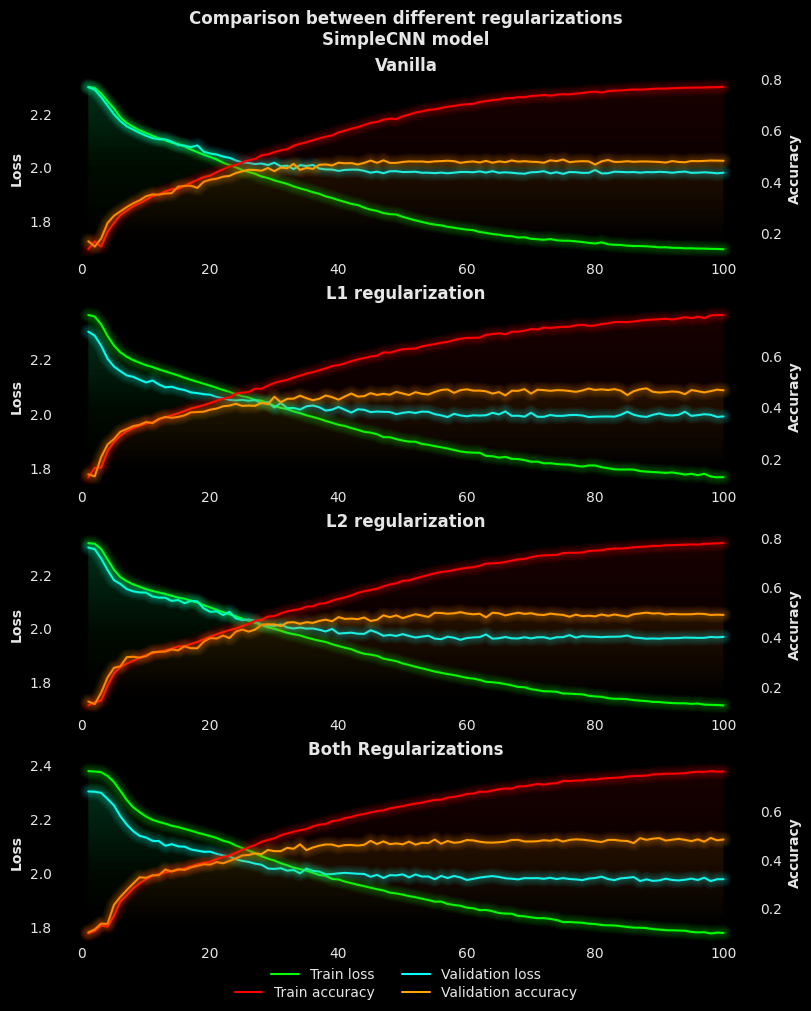

In [6]:
title = 'Comparison between different regularizations\nSimpleCNN model'
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(4, 1, layout='constrained', figsize=(8, 10))
    x_axis = range(1, PARAMS.epochs + 1)
    for ax, (model_type, 
             (train, t_acc, val, v_acc, _)) in zip(figure.axes, models_data['SimpleCNN'].items()):
        ax.set(title=model_type, ylabel='Loss')
        ax.plot(x_axis, train, label=f'Train loss', color='lime')
        ax.plot(x_axis, val, label=f'Validation loss', color='cyan')
        ax_right = ax.twinx()
        ax_right.set_ylabel('Accuracy')
        ax_right.plot(x_axis, t_acc, label=f'Train accuracy', color='red')
        ax_right.plot(x_axis, v_acc, label=f'Validation accuracy', color='orange')
        ax.grid(False)
        ax_right.grid(False)
        if ax == axes[3]:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), 
                      labelspacing=0.1, ncol=4, borderpad=0.1, markerscale=6)
            ax_right.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), 
                            labelspacing=0.1, ncol=4, borderpad=0.1, markerscale=6)
        enhance_plot(figure, ax, glow=True, alpha_gradient=0.1)
        enhance_plot(figure, ax_right, glow=True, alpha_gradient=0.1)
    figure.suptitle(title, fontweight='bold')
figure.savefig('./images/image1.png')

# VGG11 with L1, L2 and no regularization

Vanilla


100%|██████████| 100/100 [17:48<00:00, 10.69s/it]


Time: 1068.911 seconds
L1 regularization


100%|██████████| 100/100 [17:53<00:00, 10.73s/it]


Time: 1073.229 seconds
L2 regularization


100%|██████████| 100/100 [17:59<00:00, 10.79s/it]


Time: 1079.177 seconds
Both Regularizations


100%|██████████| 100/100 [18:01<00:00, 10.81s/it]


Time: 1081.055 seconds


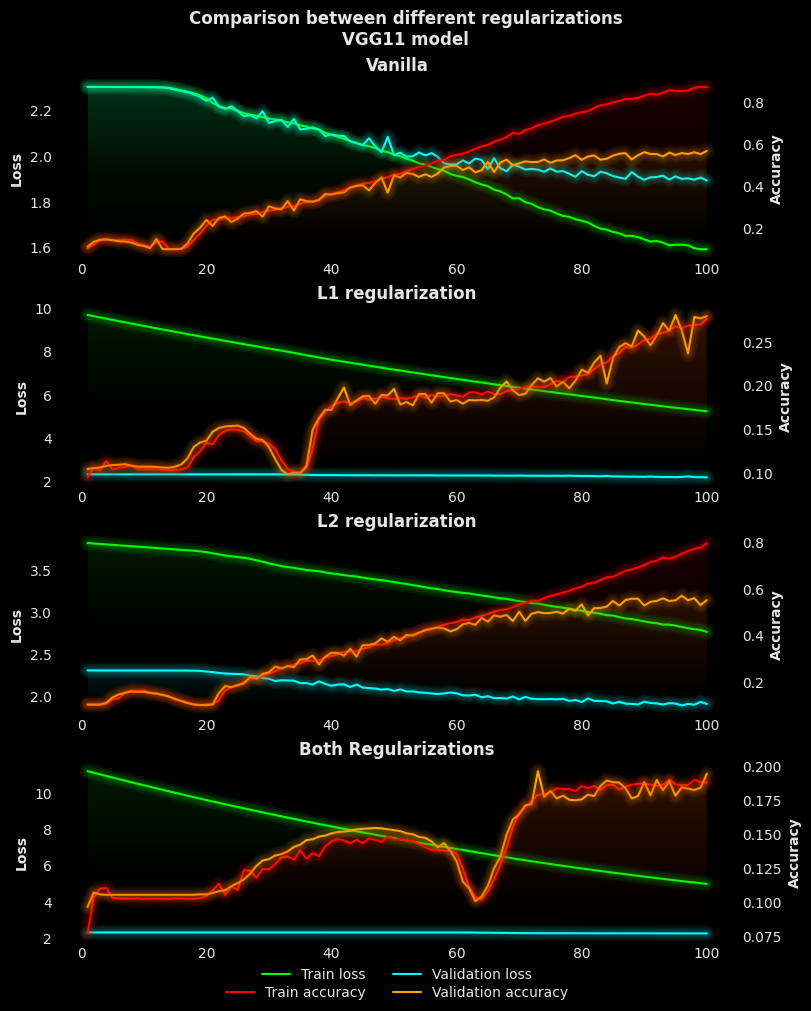

In [7]:
models_data['VGG11'] = {}
for model_name, L1, L2 in zip(model_names, L1_list, L2_list):
    print(model_name)
    model = VGG11()
    model.to(PARAMS.device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=PARAMS.learning_rate,
                                momentum=PARAMS.momentum)
    train_time_start = timer()
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    for epoch in tqdm(range(PARAMS.epochs)):
        train_metrics = train_step_with_reg(
            model, train_dataloader, loss_fn, accuracy, optimizer, PARAMS.device,
            lambda_l1=L1, lambda_l2=L2)
        test_metrics = test_step(
            model, test_dataloader, loss_fn, accuracy, PARAMS.device)
        train_loss.append(train_metrics[0])
        train_acc.append(train_metrics[1])
        val_loss.append(test_metrics[0])
        val_acc.append(test_metrics[1])
    models_data['VGG11'][model_name] = (train_loss, train_acc, val_loss, val_acc, model)
    train_time = timer() - train_time_start
    print(f'Time: {train_time:.3f} seconds')

title = 'Comparison between different regularizations\nVGG11 model'
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(4, 1, layout='constrained', figsize=(8, 10))
    x_axis = range(1, PARAMS.epochs + 1)
    for ax, (model_type, 
             (train, t_acc, val, v_acc, _)) in zip(figure.axes, models_data['VGG11'].items()):
        ax.set(title=model_type, ylabel='Loss')
        ax.plot(x_axis, train, label=f'Train loss', color='lime')
        ax.plot(x_axis, val, label=f'Validation loss', color='cyan')
        ax_right = ax.twinx()
        ax_right.set_ylabel('Accuracy')
        ax_right.plot(x_axis, t_acc, label=f'Train accuracy', color='red')
        ax_right.plot(x_axis, v_acc, label=f'Validation accuracy', color='orange')
        ax.grid(False)
        ax_right.grid(False)
        if ax == axes[3]:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), 
                      labelspacing=0.1, ncol=4, borderpad=0.1, markerscale=6)
            ax_right.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), 
                            labelspacing=0.1, ncol=4, borderpad=0.1, markerscale=6)
        enhance_plot(figure, ax, glow=True, alpha_gradient=0.1)
        enhance_plot(figure, ax_right, glow=True, alpha_gradient=0.1)
    figure.suptitle(title, fontweight='bold')
figure.savefig('./images/image2.png')

In [39]:
m = models_data['SimpleCNN']['Vanilla'][-1]

# Collecting model parameters

In [45]:
def collect_parameters(model):
    conv_weights, conv_biases = [], []
    linear_weights, linear_biases = [], []
    for name, param in model.named_parameters():
        params_numpy = param.data.view(-1).detach().cpu().numpy()
        if 'conv_layer' in name:
            if 'weight' in name:
                conv_weights.append(params_numpy)
            elif 'bias' in name:
                conv_biases.append(params_numpy)
        elif 'classifier' in name:
            if 'weight' in name:
                linear_weights.append(params_numpy)
            elif 'bias' in name:
                linear_biases.append(params_numpy)
    return (np.hstack(conv_weights), np.hstack(conv_biases),
            np.hstack(linear_weights), np.hstack(linear_biases))

In [110]:
def histograms(model_architecture, file):
    with plt.style.context('cyberpunk'):
        bins, alpha, range_ = 150, 0.5, (-0.05, 0.05)
        colors = [('blue', 'deepskyblue'), ('red', 'orange'), 
                  ('green', 'lime'), ('darkviolet', 'fuchsia')]
        figure, axes = plt.subplots(4, 2, layout='constrained', figsize=(8, 10))
        figure.suptitle(f'Model parameters histogram\n for {model_architecture}', fontweight='bold')
        hist_params = dict(bins=bins, alpha=alpha, range=range_, density=True)
        axes[0][0].set(title='Weights')
        axes[0][1].set(title='Biases')
        for index, ((color1, color2), (model_type, (_, _, _, _, model))) in enumerate(
                zip(colors, models_data[model_architecture].items())):
            model_params = collect_parameters(model)
            axes[index][0].set(ylabel=model_type)
            axes[index][0].hist(model_params[0], color=color1, label='Convolutional', **hist_params)
            axes[index][0].hist(model_params[2], color=color2, label='Linear', **hist_params)
            axes[index][1].hist(model_params[1], color=color1, label='Convolutional', **hist_params)
            axes[index][1].hist(model_params[3], color=color2, label='Linear', **hist_params)
            for index2 in (0, 1):
                axes[index][index2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), 
                                           labelspacing=0.1, ncol=2, borderpad=0.1, markerscale=6)
                enhance_plot(figure, axes[index][index2])
    figure.savefig(f'images/{file}.png')

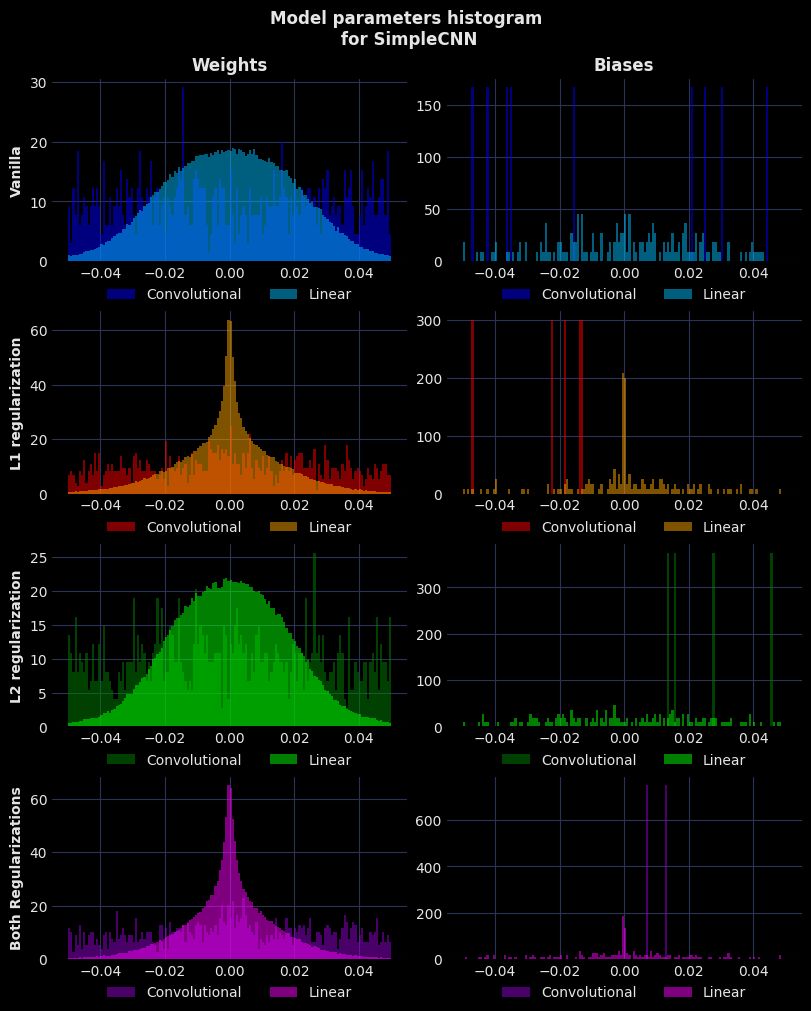

In [111]:
histograms('SimpleCNN', 'image3')

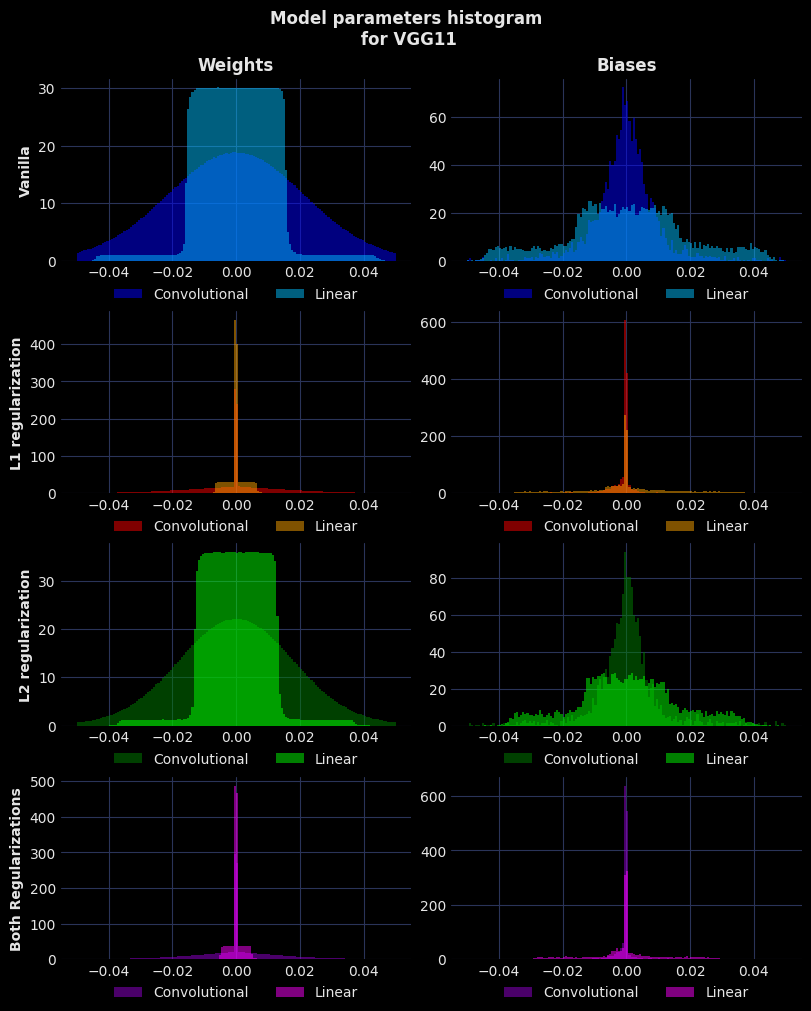

In [112]:
histograms('VGG11', 'image4')